In [1]:
import numpy as np
import GPyOpt
import time

from sklearn import datasets
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import metrics
from scipy.stats import uniform
from sklearn import linear_model, metrics
from GPyOpt.methods import BayesianOptimization
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


In [2]:
X, y = datasets.load_boston(return_X_y=True)


In [3]:
logistic = XGBRegressor()

baseline = cross_val_score(logistic, X, y, scoring='neg_mean_squared_error').mean()
print(baseline)

-26.303378073593848


In [4]:
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(logistic, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=20,  verbose=50)

# Run random search for 25 iterations
best_model_rand = rs.fit(X, y)



ypred = best_model_rand.predict(X)

print("randomSearchParams")
print(metrics.mean_squared_error(y,ypred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=46, gamma=0.8241900261632829, min_child_weight=8, n_estimators=139, learning_rate=0.3810100099059932 
[CV]  max_depth=46, gamma=0.8241900261632829, min_child_weight=8, n_estimators=139, learning_rate=0.3810100099059932, score=-13.540070797798847, total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=46, gamma=0.8241900261632829, min_child_weight=8, n_estimators=139, learning_rate=0.3810100099059932 
[CV]  max_depth=46, gamma=0.8241900261632829, min_child_weight=8, n_estimators=139, learning_rate=0.3810100099059932, score=-22.655784209839705, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=46, gamma=0.8241900261632829, min_child_weight=8, n_estimators=139, learning_rate=0.3810100099059932 
[CV]  max_depth=46, gamma=0.8

[CV]  max_depth=49, gamma=2.8046487241505047, min_child_weight=8, n_estimators=167, learning_rate=0.21765838461518694, score=-9.385440864719554, total=   0.2s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.9s remaining:    0.0s
[CV] max_depth=49, gamma=2.8046487241505047, min_child_weight=8, n_estimators=167, learning_rate=0.21765838461518694 
[CV]  max_depth=49, gamma=2.8046487241505047, min_child_weight=8, n_estimators=167, learning_rate=0.21765838461518694, score=-21.345258755742528, total=   0.2s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    3.0s remaining:    0.0s
[CV] max_depth=49, gamma=2.8046487241505047, min_child_weight=8, n_estimators=167, learning_rate=0.21765838461518694 
[CV]  max_depth=49, gamma=2.8046487241505047, min_child_weight=8, n_estimators=167, learning_rate=0.21765838461518694, score=-45.38849845624527, total=   0.1s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.1s remaining:    0.0s
[CV] max_depth=18, gamma=1.9264609131087802, m

[CV]  max_depth=20, gamma=4.9821749186277975, min_child_weight=6, n_estimators=118, learning_rate=0.5571769348332504, score=-24.661493950963706, total=   0.1s
[CV] max_depth=20, gamma=4.9821749186277975, min_child_weight=6, n_estimators=118, learning_rate=0.5571769348332504 
[CV]  max_depth=20, gamma=4.9821749186277975, min_child_weight=6, n_estimators=118, learning_rate=0.5571769348332504, score=-51.62709988384356, total=   0.1s
[CV] max_depth=42, gamma=2.128604701876631, min_child_weight=2, n_estimators=203, learning_rate=0.1701510366605251 
[CV]  max_depth=42, gamma=2.128604701876631, min_child_weight=2, n_estimators=203, learning_rate=0.1701510366605251, score=-11.25677681157335, total=   0.2s
[CV] max_depth=42, gamma=2.128604701876631, min_child_weight=2, n_estimators=203, learning_rate=0.1701510366605251 
[CV]  max_depth=42, gamma=2.128604701876631, min_child_weight=2, n_estimators=203, learning_rate=0.1701510366605251, score=-25.824180127154154, total=   0.3s
[CV] max_depth=42, 

 /Users/patrickward/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


randomSearchParams
0.43511999013707325


In [5]:
#Code for Baysian from https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

start_bay_time = time.time()
# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

print("--- %s seconds ---" % (time.time() - start_bay_time))



--- 15.147667169570923 seconds ---


In [6]:

logistic = XGBRegressor()
X, y = datasets.load_diabetes(return_X_y=True)
baseline = cross_val_score(logistic, X, y, scoring='neg_mean_squared_error').mean()

param_grid = [
  {'learning_rate': np.arange(0.0, 1.0, 0.2), 
   'gamma': range(0, 5, 1),
  'max_depth': range(1, 50, 25) ,
  'n_estimators': range(1, 300, 150),
   'min_child_weight': range(1,10,5)
  }
 ]
gridSearchParams = GridSearchCV(logistic, param_grid, cv=3, verbose=50,scoring='neg_mean_squared_error', return_train_score=True)
best_model_Search = gridSearchParams.fit(X,y)

ypred = best_model_Search.predict(X)

print("gridSearchParams")
print(metrics.mean_squared_error(y,ypred))
   

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=1, gamma=0, min_child_weight=1, n_estimators=1, learning_rate=0.0 
[CV]  max_depth=1, gamma=0, min_child_weight=1, n_estimators=1, learning_rate=0.0, score=-27487.682432432433, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, gamma=0, min_child_weight=1, n_estimators=1, learning_rate=0.0 
[CV]  max_depth=1, gamma=0, min_child_weight=1, n_estimators=1, learning_rate=0.0, score=-29398.018707482992, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, gamma=0, min_child_weight=1, n_estimators=1, learning_rate=0.0 
[CV]  max_depth=1, gamma=0, min_child_weight=1, n_estimators=1, learning_rate=0.0, score=-29891.85544217687, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s

[CV]  max_depth=26, gamma=0, min_child_weight=1, n_estimators=151, learning_rate=0.2, score=-3565.6567185193794, total=   0.1s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=26, gamma=0, min_child_weight=1, n_estimators=151, learning_rate=0.2 
[CV]  max_depth=26, gamma=0, min_child_weight=1, n_estimators=151, learning_rate=0.2, score=-4271.745077353275, total=   0.1s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=26, gamma=0, min_child_weight=1, n_estimators=151, learning_rate=0.2 
[CV]  max_depth=26, gamma=0, min_child_weight=1, n_estimators=151, learning_rate=0.2, score=-4442.87791809492, total=   0.1s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=26, gamma=0, min_child_weight=6, n_estimators=1, learning_rate=0.2 
[CV]  max_depth=26, gamma=0, min_child_weight=6, n_estimators=1, learning_rate=0.2, score=-18937.007970907, total=   0.0s
[Parall

[CV]  max_depth=26, gamma=0, min_child_weight=1, n_estimators=151, learning_rate=0.6000000000000001, score=-4628.355796890185, total=   0.0s
[CV] max_depth=26, gamma=0, min_child_weight=1, n_estimators=151, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=0, min_child_weight=1, n_estimators=151, learning_rate=0.6000000000000001, score=-4625.524470896759, total=   0.0s
[CV] max_depth=26, gamma=0, min_child_weight=1, n_estimators=151, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=0, min_child_weight=1, n_estimators=151, learning_rate=0.6000000000000001, score=-6004.274274094646, total=   0.0s
[CV] max_depth=26, gamma=0, min_child_weight=6, n_estimators=1, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=0, min_child_weight=6, n_estimators=1, learning_rate=0.6000000000000001, score=-7577.570928767394, total=   0.0s
[CV] max_depth=26, gamma=0, min_child_weight=6, n_estimators=1, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=0, min_child_wei

[CV]  max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.0, score=-29398.018707482992, total=   0.1s
[CV] max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.0 
[CV]  max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.0, score=-29891.85544217687, total=   0.1s
[CV] max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.0 
[CV]  max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.0, score=-27487.682432432433, total=   0.0s
[CV] max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.0 
[CV]  max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.0, score=-29398.018707482992, total=   0.0s
[CV] max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.0 
[CV]  max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.0, score=-29891.85544217687, total=   0.0s
[CV] max_depth=26, gamma=1, min_child_w

[CV]  max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.4, score=-3910.042928863831, total=   0.1s
[CV] max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.4 
[CV]  max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.4, score=-4555.97272924866, total=   0.1s
[CV] max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.4 
[CV]  max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.4, score=-4960.728999476503, total=   0.1s
[CV] max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.4 
[CV]  max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.4, score=-12300.30426202113, total=   0.0s
[CV] max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.4 
[CV]  max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.4, score=-13420.938685335655, total=   0.0s
[CV] max_depth=26, gamma=1, min_child_

[CV]  max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.8, score=-4533.655574231426, total=   0.1s
[CV] max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.8 
[CV]  max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.8, score=-5306.557535031215, total=   0.1s
[CV] max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.8 
[CV]  max_depth=26, gamma=1, min_child_weight=1, n_estimators=151, learning_rate=0.8, score=-5268.412432991639, total=   0.1s
[CV] max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.8 
[CV]  max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.8, score=-4768.8091021680675, total=   0.0s
[CV] max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.8 
[CV]  max_depth=26, gamma=1, min_child_weight=6, n_estimators=1, learning_rate=0.8, score=-5330.70525862076, total=   0.0s
[CV] max_depth=26, gamma=1, min_child_

[CV]  max_depth=26, gamma=2, min_child_weight=1, n_estimators=151, learning_rate=0.2, score=-3551.372166241544, total=   0.2s
[CV] max_depth=26, gamma=2, min_child_weight=1, n_estimators=151, learning_rate=0.2 
[CV]  max_depth=26, gamma=2, min_child_weight=1, n_estimators=151, learning_rate=0.2, score=-4261.071999115181, total=   0.2s
[CV] max_depth=26, gamma=2, min_child_weight=1, n_estimators=151, learning_rate=0.2 
[CV]  max_depth=26, gamma=2, min_child_weight=1, n_estimators=151, learning_rate=0.2, score=-4437.766486156244, total=   0.1s
[CV] max_depth=26, gamma=2, min_child_weight=6, n_estimators=1, learning_rate=0.2 
[CV]  max_depth=26, gamma=2, min_child_weight=6, n_estimators=1, learning_rate=0.2, score=-18937.007970907, total=   0.0s
[CV] max_depth=26, gamma=2, min_child_weight=6, n_estimators=1, learning_rate=0.2 
[CV]  max_depth=26, gamma=2, min_child_weight=6, n_estimators=1, learning_rate=0.2, score=-20423.622871980268, total=   0.0s
[CV] max_depth=26, gamma=2, min_child_w

[CV]  max_depth=26, gamma=2, min_child_weight=1, n_estimators=151, learning_rate=0.6000000000000001, score=-4726.409008271544, total=   0.1s
[CV] max_depth=26, gamma=2, min_child_weight=1, n_estimators=151, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=2, min_child_weight=1, n_estimators=151, learning_rate=0.6000000000000001, score=-4647.275140561328, total=   0.1s
[CV] max_depth=26, gamma=2, min_child_weight=1, n_estimators=151, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=2, min_child_weight=1, n_estimators=151, learning_rate=0.6000000000000001, score=-5961.250631013702, total=   0.1s
[CV] max_depth=26, gamma=2, min_child_weight=6, n_estimators=1, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=2, min_child_weight=6, n_estimators=1, learning_rate=0.6000000000000001, score=-7577.570928767394, total=   0.0s
[CV] max_depth=26, gamma=2, min_child_weight=6, n_estimators=1, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=2, min_child_wei

[CV]  max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.0, score=-29398.018707482992, total=   0.1s
[CV] max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.0 
[CV]  max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.0, score=-29891.85544217687, total=   0.1s
[CV] max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.0 
[CV]  max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.0, score=-27487.682432432433, total=   0.0s
[CV] max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.0 
[CV]  max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.0, score=-29398.018707482992, total=   0.0s
[CV] max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.0 
[CV]  max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.0, score=-29891.85544217687, total=   0.0s
[CV] max_depth=26, gamma=3, min_child_w

[CV]  max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.4, score=-3929.1417293434733, total=   0.1s
[CV] max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.4 
[CV]  max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.4, score=-4538.513765746965, total=   0.1s
[CV] max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.4 
[CV]  max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.4, score=-4980.143856511412, total=   0.1s
[CV] max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.4 
[CV]  max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.4, score=-12300.30426202113, total=   0.0s
[CV] max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.4 
[CV]  max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.4, score=-13420.938685335655, total=   0.0s
[CV] max_depth=26, gamma=3, min_chil

[CV]  max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.8, score=-4481.527228527349, total=   0.2s
[CV] max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.8 
[CV]  max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.8, score=-5208.233153725565, total=   0.2s
[CV] max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.8 
[CV]  max_depth=26, gamma=3, min_child_weight=1, n_estimators=151, learning_rate=0.8, score=-5488.276190299746, total=   0.1s
[CV] max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.8 
[CV]  max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.8, score=-4768.8091021680675, total=   0.0s
[CV] max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.8 
[CV]  max_depth=26, gamma=3, min_child_weight=6, n_estimators=1, learning_rate=0.8, score=-5330.70525862076, total=   0.0s
[CV] max_depth=26, gamma=3, min_child_

[CV]  max_depth=26, gamma=4, min_child_weight=1, n_estimators=151, learning_rate=0.2, score=-3799.8811358148564, total=   0.1s
[CV] max_depth=26, gamma=4, min_child_weight=1, n_estimators=151, learning_rate=0.2 
[CV]  max_depth=26, gamma=4, min_child_weight=1, n_estimators=151, learning_rate=0.2, score=-4258.702684344303, total=   0.1s
[CV] max_depth=26, gamma=4, min_child_weight=1, n_estimators=151, learning_rate=0.2 
[CV]  max_depth=26, gamma=4, min_child_weight=1, n_estimators=151, learning_rate=0.2, score=-4360.127029926136, total=   0.2s
[CV] max_depth=26, gamma=4, min_child_weight=6, n_estimators=1, learning_rate=0.2 
[CV]  max_depth=26, gamma=4, min_child_weight=6, n_estimators=1, learning_rate=0.2, score=-18937.007970907, total=   0.0s
[CV] max_depth=26, gamma=4, min_child_weight=6, n_estimators=1, learning_rate=0.2 
[CV]  max_depth=26, gamma=4, min_child_weight=6, n_estimators=1, learning_rate=0.2, score=-20423.622871980268, total=   0.0s
[CV] max_depth=26, gamma=4, min_child_

[CV]  max_depth=1, gamma=4, min_child_weight=6, n_estimators=151, learning_rate=0.6000000000000001, score=-3464.0029688535005, total=   0.0s
[CV] max_depth=26, gamma=4, min_child_weight=1, n_estimators=1, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=4, min_child_weight=1, n_estimators=1, learning_rate=0.6000000000000001, score=-8368.905116068647, total=   0.0s
[CV] max_depth=26, gamma=4, min_child_weight=1, n_estimators=1, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=4, min_child_weight=1, n_estimators=1, learning_rate=0.6000000000000001, score=-9296.695456144555, total=   0.0s
[CV] max_depth=26, gamma=4, min_child_weight=1, n_estimators=1, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=4, min_child_weight=1, n_estimators=1, learning_rate=0.6000000000000001, score=-8600.757726037767, total=   0.0s
[CV] max_depth=26, gamma=4, min_child_weight=1, n_estimators=151, learning_rate=0.6000000000000001 
[CV]  max_depth=26, gamma=4, min_child_weight=1,

 /Users/patrickward/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


-3498.951701204653
Random search neg. MSE =  {-25.33350983499466}
Bayesian optimization neg. MSE =  {-25.150027298211228}
Grid Search  neg. MSE =  {-3141.0404150693453}


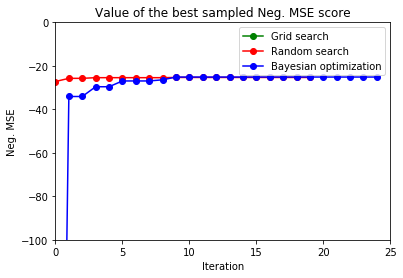

In [10]:

y_gridSearch = np.maximum.accumulate(gridSearchParams.cv_results_['mean_test_score'])
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()



print(baseline)
print('Random search neg. MSE = ' , {y_rs[-1]})
print('Bayesian optimization neg. MSE = ', {y_bo[-1]})
print('Grid Search  neg. MSE = ', {y_gridSearch[-1]})




plt.plot(y_gridSearch, 'go-', label='Grid search')
plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-100, 0)
plt.xlim(0, 25)
plt.title('Value of the best sampled Neg. MSE score');
plt.legend();